In [1]:
interactive = False
if interactive:
    %matplotlib
import numpy as np
import h5py
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import yaml
import argparse
import xml.etree.ElementTree as ET

sys.path.append('../')
import utils
import settings
plt.style.use('../spectrum.mplstyle')
if interactive:
    plt.ion()

In [2]:
def multi_exp_fit(param_data_object, t, corr, result_type="ct", v=1):
    n = [2.0,1.0,1.0,1.0]
    param_info = param_data_object['param_info'][corr].attrs
    for i in range(0,4):
        if f'N{i+2}' in param_info.keys():
            n[i] = float(param_info[f'N{i+2}'])
    param_data = param_data_object['params']['Values']
    param_samplings = [param_data[f'<MCObservable><Info>{fit_param}<|Info><|MCObservable>'][()] for fit_param in param_info['FitParams']]
    function_vals = []
    function_errs = []
    #print(param_samplings[0][0],param_samplings[0][0]+param_samplings[1][0]**2,param_samplings[0][0]+n[0]*param_samplings[1][0]**2,
    #      param_samplings[0][0]+n[1]*param_samplings[1][0]**2,param_samplings[0][0]+n[2]*param_samplings[1][0]**2,
    #      param_samplings[0][0]+n[3]*param_samplings[1][0]**2)
#     print(param_samplings[2][0], 
#                    param_samplings[3][0], param_samplings[4][0], param_samplings[5][0], 
#                    param_samplings[6][0], param_samplings[7][0])
#     print(param_samplings[4][0],param_samplings[5][0],param_samplings[6][0],param_samplings[7][0])
#     print(param_samplings[0][0],param_samplings[1][0],param_samplings[2][0],param_samplings[3][0])
    for tval in t:
        if v==1:
            if result_type=="ct":
                function_samplings = utils.multi_exp_func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                       param_samplings[3], param_samplings[4], param_samplings[5], 
                       param_samplings[6], param_samplings[7],n[0],n[1], n[2],n[3])
            else:
                function_samplings = utils.multi_exp_func_eff(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                       param_samplings[3], param_samplings[4], param_samplings[5], 
                       param_samplings[6], param_samplings[7],n[0],n[1], n[2],n[3])
        else:
            if result_type=="ct":
                func = utils.multi_exp_func
            else:
                func = utils.multi_exp_func_eff
            if len(param_samplings)==4:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], 0.0, 0.0, 0.0, param_samplings[2], 
                   param_samplings[3], 0.0, 0.0, 0.0) 
            if len(param_samplings)==6:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   0.0, 0.0, param_samplings[3], param_samplings[4], param_samplings[5], 0.0, 0.0) 
            elif len(param_samplings)==8:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   param_samplings[3], 0.0, param_samplings[4], param_samplings[5], 
                   param_samplings[6], param_samplings[7], 0.0) # param_samplings[8], param_samplings[9])
            elif len(param_samplings)==10:
                function_samplings = func(tval, param_samplings[0], param_samplings[1], param_samplings[2], 
                   param_samplings[3], param_samplings[4], param_samplings[5], 
                   param_samplings[6], param_samplings[7], param_samplings[8], param_samplings[9])
        function_vals.append(function_samplings[0])
        function_errs.append(utils.bootstrap_error_by_array(function_samplings))
    return np.array(function_vals),np.array(function_errs)

In [3]:
def get_fit_range(param_data_object, corr):
    try:
        param_info = param_data_object['param_info'][corr].attrs
        return param_info["FinalTmin"], param_info["FinalTmax"]
    except Exception as error:
        print(error)
        return None,None

In [4]:
data_files = {
    "single_hadrons.hdf5":'single_hadrons',
    "rotated_correlators-lambda.hdf5":'rotated_correlators',
    "rotated_correlators-nn.hdf5":'rotated_correlators'
}
# param_files = {
# #     "t=[2,17],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-17.hdf5",
# #     "t=[2,19],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19-3.hdf5",
# #     "t=[2,21],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-21.hdf5",
# #     "t=[2,23],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-23.hdf5",
# #     "t=[2,25],gap=2.5": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-25.hdf5",
# #     "t=[2,25],gap=2.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-2.hdf5",
#     "t=[2,25],gap=1.5": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-15.hdf5",
#     "t=[2,25],gap=1.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-125.hdf5",
#     "t=[2,25],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25.hdf5",
#     "t=[2,25],gap=0.75": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-075.hdf5",
# #     "t=[2,25],gap=0.75,0.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-075-025.hdf5",
# #     "t=[2,25],gap=0.50": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-050.hdf5",
# #     "t=[2,25],gap=0.25": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-25-025.hdf5",
# #     "t=[2,19],gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19.hdf5",
# #     "t=[2,19]*,gap=1.0": "param_samplings_isosinglet_strange_fermionic_multi_rebin10-19-2.hdf5",
# }
# param_files = {
#     "gap=0.75": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10-075.hdf5",
#     "gap=1.0": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10.hdf5",
#     "gap=1.2": "param_samplings_isosinglet_nonstrange_nucleonnucleon_multi_rebin10-12.hdf5",
# }
param_files = {
    "pwm=1.0": "param_samplings_isosinglet_strange_fermionic_multi_new10_rebin10.hdf5",
    "pwm=1.5": "param_samplings_isosinglet_strange_fermionic_multi_new15_rebin10.hdf5",
    "pwm=2.0": "param_samplings_isosinglet_strange_fermionic_multi_new20_rebin10.hdf5",
    "pwm=2.5": "param_samplings_isosinglet_strange_fermionic_multi_new25_rebin10.hdf5",
    "pwm=3.0": "param_samplings_isosinglet_strange_fermionic_multi_new30_rebin10.hdf5",
    "pwm=3.5": "param_samplings_isosinglet_strange_fermionic_multi_new35_rebin10.hdf5",
    "pwm=4.0": "param_samplings_isosinglet_strange_fermionic_multi_new40_rebin10.hdf5",
}
johns_data_file = "nucleon_d0_emass_1_0_errs.dat"
n_corr = 'isodoublet S=0 P=(0,0,0) G1g N[SS0] 0'

available_corrs = []
for file in param_files:
    param_samplings = h5py.File(param_files[file],"r")
    available_corrs += list( param_samplings['param_info'].keys() )
    param_samplings.close()

In [5]:
data_files

{'single_hadrons.hdf5': 'single_hadrons',
 'rotated_correlators-lambda.hdf5': 'rotated_correlators',
 'rotated_correlators-nn.hdf5': 'rotated_correlators'}

In [6]:
available_corrs = list(set(available_corrs))
if interactive:
    available_corrs = ['isosinglet S=-1 P=(0,0,0) G1g ROT 1']
    
# available_corrs = ['isosinglet S=0 P=(0,0,0) T1g ROT 0']
# available_corrs = [n_corr, 'isodoublet S=0 PSQ=1 G1 N[SS0] 0','isodoublet S=0 PSQ=2 G N[SS0] 0','isodoublet S=0 PSQ=3 G N[SS0] 0','isodoublet S=0 PSQ=4 G1 N[SS0] 0']

In [7]:
available_corrs

['isosinglet S=-1 PSQ=1 G1 ROT 6',
 'isosinglet S=-1 PSQ=1 G2 ROT 6',
 'isosinglet S=-1 P=(0,0,0) G1g ROT 0',
 'isosinglet S=-1 PSQ=1 G1 ROT 7',
 'isosinglet S=-1 PSQ=3 F2 ROT 5',
 'isosinglet S=-1 PSQ=3 F1 ROT 2',
 'isosinglet S=-1 PSQ=2 G ROT 3',
 'isosinglet S=-1 PSQ=1 G2 ROT 3',
 'isosinglet S=-1 PSQ=2 G ROT 1',
 'isosinglet S=-1 PSQ=1 G1 ROT 1',
 'isosinglet S=-1 PSQ=1 G2 ROT 5',
 'isosinglet S=-1 PSQ=3 G ROT 6',
 'isosinglet S=-1 P=(0,0,0) Hu ROT 0',
 'isosinglet S=-1 PSQ=3 G ROT 1',
 'isosinglet S=-1 PSQ=3 G ROT 8',
 'isosinglet S=-1 P=(0,0,0) G1u ROT 1',
 'isosinglet S=-1 PSQ=1 G1 ROT 5',
 'isosinglet S=-1 PSQ=1 G1 ROT 3',
 'isosinglet S=-1 PSQ=3 G ROT 5',
 'isosinglet S=-1 PSQ=1 G1 ROT 4',
 'isosinglet S=-1 PSQ=2 G ROT 2',
 'isotriplet S=0 P=(0,0,0) A1um P[SS0] 0',
 'isosinglet S=-1 PSQ=2 G ROT 0',
 'isosinglet S=-1 PSQ=3 G ROT 9',
 'isosinglet S=-1 PSQ=3 F1 ROT 3',
 'isosinglet S=-1 PSQ=2 G ROT 14',
 'isosinglet S=-1 PSQ=1 G1 ROT 2',
 'isodoublet S=-2 P=(0,0,0) G1g X[SS0] 0',

In [8]:
omit = {}
fit_range = {}
chi2 = {}
for corr in available_corrs:
    fit_range[corr] = {}
    chi2[corr] = {}
for dataset in param_files.keys():
    hdf5_data = h5py.File(param_files[dataset],"r")
    for corr in available_corrs:
        tmin, tmax = get_fit_range(hdf5_data,corr)
        if tmin is not None:
            fit_range[corr][dataset] = tmax-tmin
            chi2[corr][dataset] = hdf5_data['param_info'][corr].attrs['ChiSquarePerDof']
    hdf5_data.close()
            
for corr in available_corrs:
    omit[corr] = []

isosinglet S=-1 PSQ=1 G1 ROT 6
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.509585993441659, 2.0408447956112785, 0.9999999999999996, 0.5137894592125499, 0.27240052214315535, 0.1476588770470534, 0.08127203271536208, 0.045229563243579365, 0.025385504661588176, 0.014323306583564174, 0.008138411972613602, 0.004635478718479852, 0.002636422688043721, 0.0015119567456900872, 0.000864489418818089, 0.0005000649458904105, 0.00028417913158741123, 0.00016662369152915343, 9.383942116579365e-05, 5.507706131661862e-05, 2.9396792132105286e-05, 1.7337719971639663e-05, 1.1188742213772759e-05, 7.046846307183487e-06]
[] []


..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=1 G2 ROT 6
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [5.645841692861872, 2.302238908678112, 0.9999999999999992, 0.451489721054077, 0.20945857228034825, 0.09909629243209817, 0.04763803313220868, 0.023164177976695222, 0.011397556769410908, 0.005639392428331876, 0.0028148309643454485, 0.0014106833195134106, 0.0007150698324184012, 0.00036887155425087106, 0.00018648811774841275, 8.791974972466192e-05, 4.428650137046802e-05, 2.3593315842027868e-05, 1.1358449658196828e-05, 7.27361093959429e-06, 5.689075834617902e-06, 2.453717424988487e-06, 2.8873360409647444e-06, 2.3900161914837028e-06]
[] []


..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 P=(0,0,0) G1g ROT 0
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [2.903740938459561, 1.6501177487538263, 0.9999999999999997, 0.6295905134971046, 0.40655535799095543, 0.26721350436733177, 0.17792262047648827, 0.11959017890539574, 0.08092232878965792, 0.05505474637700988, 0.037615228806901546, 0.025818611436776103, 0.017779271246724695, 0.01227894551050574, 0.00849131076930706, 0.005878994309044041, 0.00407951458613329, 0.0028283112416418125, 0.001960398306025693, 0.001358831595155556, 0.0009477196417505288, 0.0006591476113224552, 0.00045994654152980215, 0.0003217487972105833]
[] []
isosinglet S=-1 PSQ=1 G1 ROT 7
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.320903202535581, 2.0208373653988643, 1.0000000000000016, 0.511572369522564, 0.2678209910010159, 0.14241114997980445, 0.076638619632079, 0.041581861735864055, 0.022725545683667768, 0.012522188957949404, 0.0069659061464

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=3 F2 ROT 5
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.773522178530969, 2.1177878630637084, 0.9999999999999997, 0.48979656971907404, 0.2460698095923885, 0.12586177431237836, 0.06525217544221157, 0.034182698663896845, 0.018058561238187616, 0.009617230592971494, 0.00513554748932618, 0.0027548480159750627, 0.0014864764557832371, 0.0008064625124940582, 0.0004337506293353711, 0.00024008087717393973, 0.00013095187139687114, 6.695002083347057e-05, 3.7060468612859685e-05, 2.221211043454116e-05, 1.2374067632833032e-05, 7.044545852978977e-06, 5.681381329286241e-06, 4.276876151328843e-06]
[] []


..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=3 F1 ROT 2
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.961015300551512, 2.120396023847063, 0.9999999999999992, 0.5003020419459246, 0.26018105780801065, 0.13902212385436238, 0.07579056165037604, 0.041909610087039986, 0.023399437649822774, 0.013167814395621952, 0.007463848940601273, 0.004253172262424368, 0.002435017405640328, 0.001400750416238611, 0.0008082150876173611, 0.000466437195534769, 0.0002706063190928882, 0.00015678585824446695, 9.15132481217953e-05, 5.291115787287735e-05, 3.069648202472742e-05, 1.8589254378372205e-05, 1.1218739415394447e-05, 6.216213062373406e-06]
[] []
isosinglet S=-1 PSQ=2 G ROT 3
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.506616583265466, 2.025508554435729, 1.0000000000000007, 0.5222188637513898, 0.2829248707474684, 0.15726715316642176, 0.08905674829472955, 0.05107028709833164, 0.029564720035611385, 0.017231419344077514, 0.01010509

isosinglet S=-1 PSQ=3 G ROT 5
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.623086001611398, 2.0523964491251383, 1.0000000000000004, 0.5150206134535324, 0.27501438599932576, 0.15058475507762076, 0.08396422384845564, 0.047415892892944116, 0.027016630621728665, 0.015488757878164876, 0.008935666050206844, 0.00519016992405001, 0.0030230928354401205, 0.0017733352585965366, 0.0010388037610744667, 0.000611841055975867, 0.00036288294176302626, 0.0002132402157999228, 0.00012585107097941666, 7.468758162493337e-05, 4.434938296096241e-05, 2.6041979660742353e-05, 1.5387427176132737e-05, 8.775560765604993e-06]
[] []
isosinglet S=-1 PSQ=1 G1 ROT 4
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.4399555037679015, 2.011134331838475, 1.0000000000000007, 0.5258342038916396, 0.28687911812133393, 0.1605832477018414, 0.09160143253653819, 0.05295766063978577, 0.030896231262656358, 0.018161270869383357, 0.010

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=1 G1 ROT 2
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [3.9861184192622288, 1.9186612383878743, 1.0000000000000007, 0.5464038639706617, 0.3079995526206292, 0.17739044702774698, 0.10384176867614191, 0.06148956073723057, 0.03670004282787029, 0.02205979298316089, 0.013331974806808516, 0.008107675212661578, 0.004946187283342639, 0.0030291686797471614, 0.001858582568107332, 0.0011427003006867066, 0.0007058330405880945, 0.000435438283682017, 0.00026796969426539394, 0.00016608210738869406, 0.00010281232167508578, 6.387133700874097e-05, 3.929659001968021e-05, 2.491112819185665e-05]
[] []
isodoublet S=-2 P=(0,0,0) G1g X[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.08298772485355341, 0.045634989890299314, 0.02660104693146647, 0.01604272824924257, 0.009897101359868295, 0.006200450474212837, 0.003929595460587068, 0.002510762180310408, 0.0016134232736172201, 0.001042135066880

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 P=(0,0,0) G1u ROT 0
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [3.618195942878169, 1.8302210353097261, 1.0000000000000004, 0.5717659920737677, 0.336776590267794, 0.2024897538089549, 0.1235674518012238, 0.07619327837469306, 0.04731524194471621, 0.02957810553570429, 0.018575656470696925, 0.011704134691055166, 0.007418256850120069, 0.004713284122153635, 0.003001023774933022, 0.0019184806443657404, 0.0012271912102026228, 0.0007872679827460439, 0.0005058060162392567, 0.00032310754030616824, 0.00020860341741487154, 0.0001352256179683019, 8.785058212810357e-05, 5.6277968705703885e-05]
[] []
isotriplet S=-1 PSQ=2 G S[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.7563017577751596, 0.4137070760984816, 0.24074463207086977, 0.14527082141812214, 0.08978780756928231, 0.056429495896413794, 0.03589793188376761, 0.023038092340598098, 0.01487542997499519, 0.009657042825224945, 0.00629

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=2 G ROT 4
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.414868767430805, 2.0089005809011233, 1.000000000000002, 0.524867977764971, 0.28517936330668753, 0.15865694814087938, 0.08977779238465923, 0.0514192096919246, 0.029679351337272453, 0.01724524145855118, 0.010076705638744724, 0.005917370002236657, 0.003486413614178806, 0.002064187670463311, 0.0012236582700049193, 0.000727707110164816, 0.0004337354810772538, 0.0002587893604397219, 0.00015361590967932968, 9.195428539170341e-05, 5.486693547233187e-05, 3.309144756769137e-05, 1.9610767765701923e-05, 1.1902475152114403e-05]
[] []
isosinglet S=-1 PSQ=3 G ROT 11
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [5.73846731371308, 2.300526957318624, 1.0000000000000002, 0.457496151150289, 0.21706189710429685, 0.10563366349954667, 0.052466482690987463, 0.026553257629336625, 0.01361608921452809, 0.0070346548649022475, 0.0036767234

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 P=(0,0,0) G1u ROT 6
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [4.628189222514292, 2.0768754244374943, 1.000000000000002, 0.5019878954170285, 0.25915457867856245, 0.13641582916051695, 0.07284814725513816, 0.03928052236573509, 0.021390842689901993, 0.011711588096698644, 0.006466686329169306, 0.0036130195831886288, 0.00201842661757797, 0.001111008240693517, 0.0006368371881629737, 0.0003656578190773597, 0.00020282045749702633, 0.00011406714981654023, 6.473237909067308e-05, 3.192899584412813e-05, 1.6016067355255112e-05, 6.966907285973075e-06, 5.73264829188785e-06, 7.986715110010085e-06]
[] []


..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isodoublet S=0 PSQ=1 G1 N[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.4065025746899944, 0.23452674810656246, 0.14463135133795504, 0.09284155942178858, 0.06120531124169946, 0.0411182060392769, 0.028023498063749593, 0.019293385930890073, 0.013386129975656719, 0.009340464189851325, 0.0065516919389205, 0.004617513142933881, 0.0032693433592446224, 0.002320937750104607, 0.0016515012749871941, 0.001176355965050854, 0.0008425281268754035, 0.0006020320397553525, 0.00043076958844586626, 0.00030729865243374864, 0.00021985217671283903, 0.00015888495899654188, 0.00011428853116802235, 8.212412136778644e-05]
[] []
[] []
isodoublet S=0 PSQ=2 G N[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.7340716783748511, 0.41820952354231095, 0.2546922636307778, 0.1614425431072107, 0.10506723439259283, 0.06965768090591816, 0.04684665363507084, 0.03181009995787048, 0.02175975217372645, 0.014969875625690026, 0.

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 P=(0,0,0) G1g L[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.052986653686326206, 0.030148906885305943, 0.018265639242397734, 0.011487958381028038, 0.007407936228113627, 0.004861236236404789, 0.003231663823308333, 0.0021688109709295496, 0.0014653478093850092, 0.0009955179827815636, 0.0006793035987947106, 0.0004657145358264256, 0.00032033664758898906, 0.00022102215015270114, 0.0001527185739554704, 0.0001056314489053884, 7.326491734624069e-05, 5.075786062127053e-05, 3.516035379601732e-05, 2.4351431893816993e-05, 1.6972431701728394e-05, 1.1799866368381638e-05, 8.234190289461105e-06, 5.755950854369765e-06]
[] []
[] []
isosinglet S=-1 PSQ=3 G ROT 10
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [5.076755750486024, 2.152135627071252, 1.0, 0.4909596233214757, 0.24985213039905366, 0.13045052243854746, 0.06937654401856184, 0.03739162555659293, 0.02032265580862513, 0.011137581015

..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isosinglet S=-1 PSQ=2 G ROT 12
[] []
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [5.916008596541264, 2.3360930723064137, 1.0000000000000002, 0.45053592697686967, 0.21025008789659652, 0.10060816401736027, 0.04920986382791166, 0.02437661387813551, 0.012270253457103617, 0.006233918034903721, 0.0032053958071638425, 0.0016604666632565614, 0.0008792079615483204, 0.0004669792395769277, 0.00024176507710994933, 0.00013100677703587336, 6.879219739181225e-05, 3.709382984967313e-05, 2.2393381851076336e-05, 1.0926523785334628e-05, 5.590996787388242e-06, 6.274945568493611e-06, 2.928556219666978e-06, 2.159201401014158e-06]
[] []


..\utils.py:22: RuntimeWarning: invalid value encountered in log
  return t[:-1]+0.5*(t[1]-t[0]), np.log( C[:-1]/C[1:] )


isodoublet S=-1 PSQ=2 A2 k[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [3401.544094250611, 2517.066827399201, 1923.4850361883186, 1498.2293908033064, 1181.3958906379537, 939.323373759114, 751.1185160584934, 602.9712725447271, 485.125691700301, 391.0650064240226, 315.6359135114587, 255.10207229218, 206.2958267404029, 167.0015333779537, 135.27518288260555, 109.60490269296032, 88.83182269774787, 72.00935529280119, 58.36271048793918, 47.31371895278452, 38.363611594660235, 31.120730032685778, 25.240792497315557, 20.479463757029144]
[] []
[] []
isodoublet S=-1 P=(0,0,0) A1u k[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [589.8192826972465, 462.3548326440542, 373.6255038534519, 307.5400995481155, 256.1718580175789, 215.10801500253692, 181.61263107897673, 153.8997412820057, 130.68447533381106, 111.16500047802285, 94.66398431805288, 80.70265424641937, 68.84182391687347, 58.773311939791306, 50.

isodoublet S=-1 PSQ=1 A2 k[SS1] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [2313.4363344806357, 1761.0852153576188, 1382.4592966533971, 1105.4318446236157, 894.4862524731811, 729.6182219639022, 598.4323097861175, 492.66795047473397, 406.4508673917726, 335.94216625156923, 277.97954007566227, 230.30502282997043, 190.92095902169302, 158.42367898704262, 131.5327908755528, 109.23999909828935, 90.74414525562588, 75.39141569717718, 62.62380850939482, 52.02326003969101, 43.231999271124366, 35.93687694620197, 29.87060917237905, 24.833366974734925]
[] []
[] []
isotriplet S=-1 P=(0,0,0) G1g S[SS0] 0
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] [0.07682746921746253, 0.04297016729070189, 0.02554708509915179, 0.01575099703582827, 0.009950680470531076, 0.0063948897868791365, 0.004161739057763019, 0.002733526414891381, 0.0018068998472521444, 0.001201346021998035, 0.0008022310685028059, 0.0005379368698708349, 0.

<ipython-input-9-ec4452c827f1>:80: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  john_data = pd.read_csv(johns_data_file, header=None,skiprows=6,delimiter="   ")


IndexError: list index out of range

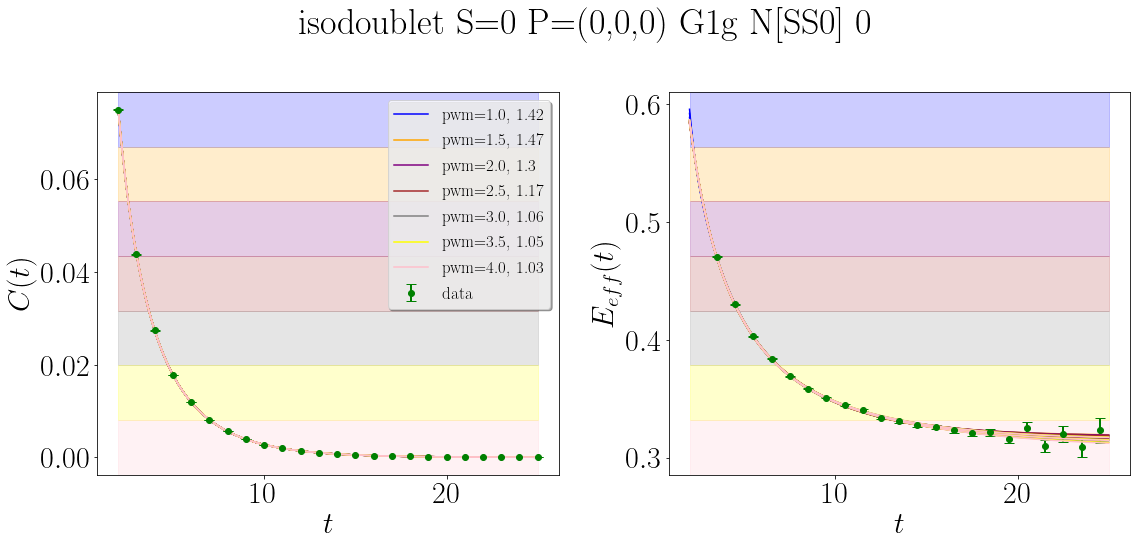

In [9]:
f, (ax1, ax2) = plt.subplots(1,2)
f.set_figwidth(16)
f.set_figheight(8)
plot_tmin = 2
for corr in available_corrs:
    print(corr)
    ax1.clear()
    ax2.clear()
    f.suptitle(corr.replace("_"," "))
    i=0
    for data_file in data_files.keys():
        hdf5_data = h5py.File(data_file,"r")
        this_t, this_corr, this_err = utils.collectCorrEstimates(hdf5_data,corr,tag=data_files[data_file])
        if this_t:
            itmin = np.where(np.array(this_t)>=plot_tmin)[0][0]
            ax1.errorbar( this_t[itmin:], this_corr[itmin:],this_err[itmin:], label="data",  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        this_t, this_corr, this_err = utils.collectEnergyEstimates(hdf5_data,corr,tag=data_files[data_file])
        if this_t:
            itmin = np.where(np.array(this_t)>=plot_tmin)[0][0]
            ax2.errorbar( this_t[itmin:], this_corr[itmin:],this_err[itmin:], label="data",  color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
#         this_t, this_corr, this_err = utils.collectEnergyEstimates(hdf5_data,corr,tag=data_files[data_file],func=2)
#         if this_t:
#             ax2.errorbar( this_t, this_corr,this_err, label="data*",  color=settings.colors[i],mfc="white", marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0 )
        hdf5_data.close()
    i=1
    for dataset in param_files.keys():
        if dataset not in omit[corr]:
            hdf5_data = h5py.File(param_files[dataset],"r")
            tmin, tmax = get_fit_range(hdf5_data,corr)
            if tmin is not None:
                t = np.linspace(2.0,25.0,1000)
                itmin = np.where(t>=tmin)[0][0]
                itmax = np.where(t>=tmax)[0][0]
#                 itmin = np.where(t>=plot_tmin)[0][0]
                fit_vals = np.array([])
                try:
                    fit_vals, fit_errs = multi_exp_fit(hdf5_data,t,corr,"ct",2)
                except Exception as error:
                    print(error) #pass
                data_label = f"{dataset}, {round(hdf5_data['param_info'][corr].attrs['ChiSquarePerDof'],2)}"
                if fit_vals.any():
    #                 ax1.plot(t,fit_vals,ls="--",color=settings.colors[i])
    #                 ax1.plot(t,fit_vals+fit_errs,ls="--",color=settings.colors[i])
    #                 ax1.plot(t,fit_vals-fit_errs,ls="--",color=settings.colors[i])
                    ax1.axvspan(tmin, tmax, ymin=1.0-(i)/len(param_files),ymax=1.0-(i-1)/len(param_files), alpha=0.2,color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax],label=data_label,color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax]+fit_errs[itmin:itmax],color=settings.colors[i])
                    ax1.plot(t[itmin:itmax],fit_vals[itmin:itmax]-fit_errs[itmin:itmax],color=settings.colors[i])

                fit_vals = np.array([])
                try:
                    fit_vals, fit_errs = multi_exp_fit(hdf5_data,t,corr,"eff",2)
                except Exception as error:
                    print(error) #pass

                if fit_vals.any():
#                     try:
#                         stable_itmin = np.where(fit_errs>1.0)[0][-1]
#                     except:
#                         stable_itmin = np.where(fit_errs<1.0)[0][0]
                    ax2.axvspan(tmin, tmax, ymin=1.0-(i)/len(param_files),ymax=1.0-(i-1)/len(param_files), alpha=0.2,color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:]+fit_errs[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmax:],fit_vals[itmax:]-fit_errs[itmax:],ls="--",color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax],label=data_label,color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax]+fit_errs[itmin:itmax],color=settings.colors[i])
                    ax2.plot(t[itmin:itmax],fit_vals[itmin:itmax]-fit_errs[itmin:itmax],color=settings.colors[i])

                hdf5_data.close()
                i+=1
    
    ax1.set_xlabel("$t$")
    ax1.set_ylabel("$C(t)$")
    ax2.set_xlabel("$t$")
    ax2.set_ylabel("$E_{eff}(t)$")
    ax1.legend()
        
    if corr==n_corr:
        john_data = pd.read_csv(johns_data_file, header=None,skiprows=6,delimiter="   ")
        ax2.errorbar(john_data[0],john_data[1],john_data[2],label="john",color=settings.colors[i], marker=settings.markers[i], linewidth=0.0, elinewidth=2.0, capsize=5.0)
#         ax2.legend()
        
    plt.tight_layout()
    plt.savefig(corr+".png")

In [ ]:
hdf5_data = h5py.File("param_samplings_isosinglet_strange_fermionic_multi_rebin10.hdf5","r")
print(hdf5_data['params']['Values'].keys() )
hdf5_data.close()

In [ ]:

hdf5_data.close()